# Modèles 

In [1]:
import pandas as pd
import numpy as np

from statistics import mean 
from tqdm.notebook import tqdm

%run '1 - Exploration.ipynb'

Dans cette partie on va essayer d'utiliser des modèles d'apprentissage machine pour prédire les scores des joueurs. On commence par récupérer le dataset et le mettre en forme pour l'apprentissage.

Les choix que l'on fait sont les suivants :
  - On ne garde pas les variables qui dépendent du match :
      - list_var_avg + WIN
  - On ne garde pas les variables qui nous donne aucune information : 
      - SEASON_ID, GAME_ID
  - On modifie le type de la variable PLAYER_ID pour pas qu'elle soit considérée comme un nombre
  - On ne garde pas les variables agrégées sur les équipes car elles sont trop souvent `Nan` car les équipes ne se jouent pas souvent (4 fois max)

In [2]:
# La liste des variables dont on va récupérer les moyennes
list_var_avg = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FTM', 'FG3M',
                 'TOV', 'FGF', 'FG3F', 'FTF', 'BONUS', 'MALUS', 'SCORE']

In [3]:
# Récupere le dataset
df = pd.read_csv('../data/boxscore_2019_final.csv')

df = df.drop(list_var_avg[:-1]+['WIN', 'SEASON_ID', 'GAME_ID'], axis=1)
df = df[~df.AVG_SCORE.isna()]

df.PLAYER_ID = df.PLAYER_ID.astype(object)

# Pour l'instant on retire aussi les variables de moyenne par équipe car elles 
# sont trop souvant vide
df = df.drop(['AVG_ADD_'+x for x in list_var_avg]+['AVG_BONUS', 'AVG_MALUS', 'AVG_SCORE'], axis=1)

# On transforme les variables catégorielles en encodage oneshot
df_model = pd.get_dummies(df, columns=['PLAYER_ID', 'TEAM', 'ADV'])

In [4]:
df_model.sample(3)

,GAME_DATE,HOME,SCORE,AVG_PTS,AVG_REB,AVG_AST,AVG_STL,AVG_BLK,AVG_FGM,AVG_FTM,AVG_FG3M,AVG_TOV,AVG_FGF,AVG_FG3F,AVG_FTF,NB_VIC,NB_VIC_ADD,PLAYER_ID_1713,PLAYER_ID_2199,PLAYER_ID_2544,PLAYER_ID_2546,PLAYER_ID_2594,PLAYER_ID_2617,PLAYER_ID_2730,PLAYER_ID_2738,PLAYER_ID_2747,PLAYER_ID_2772,PLAYER_ID_101107,PLAYER_ID_101108,PLAYER_ID_101133,PLAYER_ID_101139,PLAYER_ID_101141,PLAYER_ID_101150,PLAYER_ID_200746,PLAYER_ID_200752,PLAYER_ID_200755,PLAYER_ID_200757,PLAYER_ID_200765,PLAYER_ID_200768,PLAYER_ID_200782,PLAYER_ID_200794,PLAYER_ID_200826,PLAYER_ID_201143,PLAYER_ID_201144,PLAYER_ID_201145,PLAYER_ID_201147,PLAYER_ID_201149,PLAYER_ID_201152,PLAYER_ID_201158,PLAYER_ID_201162,PLAYER_ID_201163,PLAYER_ID_201188,PLAYER_ID_201229,PLAYER_ID_201565,PLAYER_ID_201566,PLAYER_ID_201567,PLAYER_ID_201568,PLAYER_ID_201569,PLAYER_ID_201571,PLAYER_ID_201572,PLAYER_ID_201577,PLAYER_ID_201580,PLAYER_ID_201584,PLAYER_ID_201586,PLAYER_ID_201587,PLAYER_ID_201588,PLAYER_ID_201599,PLAYER_ID_201609,PLAYER_ID_201933,PLAYER_ID_201935,PLAYER_ID_201937,PLAYER_ID_201939,PLAYER_ID_201942,PLAYER_ID_201949,PLAYER_ID_201950,PLAYER_ID_201952,PLAYER_ID_201959,PLAYER_ID_201960,PLAYER_ID_201961,PLAYER_ID_201976,PLAYER_ID_201980,PLAYER_ID_201988,PLAYER_ID_202066,PLAYER_ID_202083,PLAYER_ID_202323,PLAYER_ID_202324,PLAYER_ID_202329,PLAYER_ID_202330,PLAYER_ID_202331,PLAYER_ID_202334,PLAYER_ID_202335,PLAYER_ID_202339,PLAYER_ID_202340,PLAYER_ID_202355,PLAYER_ID_202357,PLAYER_ID_202397,PLAYER_ID_202498,PLAYER_ID_202681,PLAYER_ID_202683,PLAYER_ID_202684,PLAYER_ID_202685,PLAYER_ID_202687,PLAYER_ID_202688,PLAYER_ID_202689,PLAYER_ID_202692,PLAYER_ID_202693,PLAYER_ID_202694,PLAYER_ID_202695,PLAYER_ID_202696,PLAYER_ID_202697,PLAYER_ID_202699,PLAYER_ID_202704,PLAYER_ID_202709,PLAYER_ID_202710,PLAYER_ID_202711,PLAYER_ID_202718,PLAYER_ID_202722,PLAYER_ID_202734,PLAYER_ID_202738,PLAYER_ID_202954,PLAYER_ID_203076,PLAYER_ID_203077,PLAYER_ID_203078,PLAYER_ID_203079,PLAYER_ID_203081,PLAYER_ID_203082,PLAYER_ID_203083,PLAYER_ID_203084,PLAYER_ID_203085,PLAYER_ID_203086,PLAYER_ID_203087,PLAYER_ID_203089,PLAYER_ID_203090,PLAYER_ID_203095,PLAYER_ID_203107,PLAYER_ID_203109,PLAYER_ID_203110,PLAYER_ID_203114,PLAYER_ID_203115,PLAYER_ID_203118,PLAYER_ID_203124,PLAYER_ID_203145,PLAYER_ID_203200,PLAYER_ID_203210,PLAYER_ID_203382,PLAYER_ID_203457,PLAYER_ID_203458,PLAYER_ID_203459,PLAYER_ID_203460,PLAYER_ID_203463,PLAYER_ID_203468,PLAYER_ID_203469,PLAYER_ID_203471,PLAYER_ID_203473,PLAYER_ID_203476,PLAYER_ID_203482,PLAYER_ID_203484,PLAYER_ID_203486,PLAYER_ID_203487,PLAYER_ID_203488,PLAYER_ID_203490,PLAYER_ID_203493,PLAYER_ID_203496,PLAYER_ID_203497,PLAYER_ID_203500,PLAYER_ID_203501,PLAYER_ID_203503,PLAYER_ID_203504,PLAYER_ID_203506,PLAYER_ID_203507,PLAYER_ID_203516,PLAYER_ID_203521,PLAYER_ID_203524,PLAYER_ID_203526,PLAYER_ID_203552,PLAYER_ID_203584,PLAYER_ID_203585,PLAYER_ID_203648,PLAYER_ID_203658,PLAYER_ID_203705,PLAYER_ID_203894,PLAYER_ID_203895,PLAYER_ID_203897,PLAYER_ID_203901,PLAYER_ID_203903,PLAYER_ID_203914,PLAYER_ID_203915,PLAYER_ID_203918,PLAYER_ID_203920,PLAYER_ID_203922,PLAYER_ID_203924,PLAYER_ID_203925,PLAYER_ID_203926,PLAYER_ID_203932,PLAYER_ID_203933,PLAYER_ID_203935,PLAYER_ID_203937,PLAYER_ID_203939,PLAYER_ID_203943,PLAYER_ID_203944,PLAYER_ID_203952,PLAYER_ID_203953,PLAYER_ID_203954,PLAYER_ID_203957,PLAYER_ID_203960,PLAYER_ID_203967,PLAYER_ID_203991,PLAYER_ID_203992,PLAYER_ID_203994,PLAYER_ID_203998,PLAYER_ID_203999,PLAYER_ID_204001,PLAYER_ID_204020,PLAYER_ID_204025,PLAYER_ID_204038,PLAYER_ID_204060,PLAYER_ID_204456,PLAYER_ID_1626143,PLAYER_ID_1626144,PLAYER_ID_1626145,PLAYER_ID_1626147,PLAYER_ID_1626149,PLAYER_ID_1626153,PLAYER_ID_1626156,PLAYER_ID_1626157,PLAYER_ID_1626158,PLAYER_ID_1626159,PLAYER_ID_1626161,PLAYER_ID_1626162,PLAYER_ID_1626163,PLAYER_ID_1626164,PLAYER_ID_1626166,PLAYER_ID_1626167,PLAYER_ID_1626168,PLAYER_ID_1626169,PLAYER_ID_1626170,PLAYER_ID_1626171,PLAYER_ID_1626172,PLAYER_ID_1626174,PLAYER_ID_1626178,PLAYER_ID_1626179,PLAYER_ID_1626181,PLAYER_ID_1626187,PLAYER_ID_1626

## 1 - Modèles linéaires

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [6]:
def afficher_model(model, X, y):
    plt.figure(figsize=(8,8))

    plt.scatter(y, model.predict(X))
    plt.plot([0,100], [0,100], color='red', label='bissectrice')

    plt.title('Le score pour chaque match et chaque joueur comparé à notre prédiction',
              fontsize=15)
    plt.xlabel('Score réel', fontsize=15)
    plt.ylabel('Score prédit', fontsize=15)

    plt.legend()
    plt.show()

In [7]:
# On sépare notre base en les variables explicatives et la variable expliquée.
X = df_model.drop(['SCORE', 'GAME_DATE'], axis=1)
y = df_model.SCORE

# On choisi un hyperparamètre aléatoirement
alpha=0.2

### Ridge

In [8]:
model = Ridge(alpha=alpha)
model.fit(X,y)

R = model.score(X, y)
MSE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MSE = {MSE:.3}')

R^2 = 0.459, MSE = 8.24


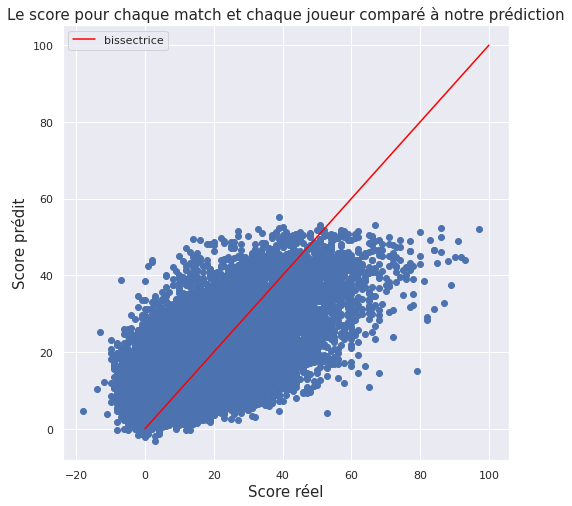

In [9]:
afficher_model(model, X, y)

### Lasso

In [10]:
model = Lasso(alpha=alpha)
model.fit(X,y)

R = model.score(X, y)
MSE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MSE = {MSE:.3}')

R^2 = 0.392, MSE = 8.75


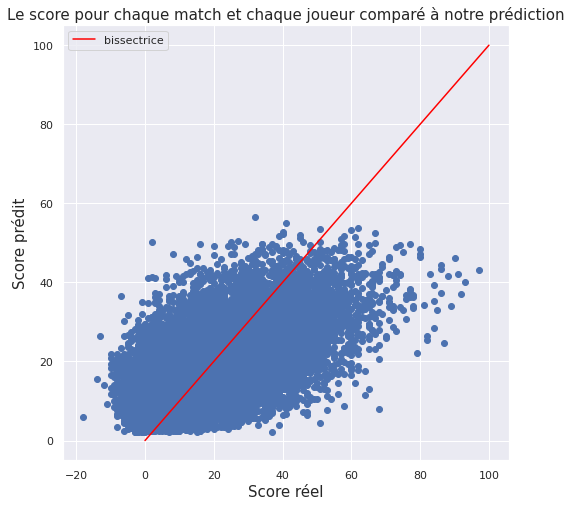

In [11]:
afficher_model(model, X, y)

## 2 - Séparation de la base et évaluation

Pour pouvoir évaluer les différents modèles que nous allons utiliser Sélim nous a conseillé de faire une *K-fold cross validation* qui très grossièrement consiste à tester son modèles sur différentes partie du data set pour mesurer sa robustesse.

Dans le cas de données temporelles, on ne peut pas simplement prendre des parties aléatoires car on risquerait d'avoir des données du futur dans notre base d'entrainement et des données du passé dans celle de test. On se base sur cet [article](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4) pour les différentes méthodes de *cross-validation* dans des séries temporelles.

Les deux méthodes simples que l'on retient sont :
  - *Time Series Split Cross-Validation*
  - *Blocked Cross-Validation*

IMAGE 1 // IMAGE 2

La deuxième est utilisée lorsque l'on suspecte que connaitre des données futurs peut permetre de prédire plus précisément des données passées. Comme nous partons du principe que la probabilité de faire un bon score ne dépend que du passé et jamais du futur nous avons décidé d'implémenter la méthode *Time Serie Split Cross-Validation*

In [12]:
# Le nombre de cross validation+1 que l'on veut
K=6

In [13]:
# On récupère les dates pour les séparer en K parties
dates = df.GAME_DATE.sort_values().unique()

# On crée les critères de séléction la base
criteres = [df_model.GAME_DATE.between(x[0], x[-1]) for x in 
                                                    np.array_split(dates, K)]
valeurs = range(K)

# On créé la variable de découpe
df_model = df_model.assign(SPLIT=np.select(criteres, valeurs, df.GAME_DATE))

# On créé les dataframes
df_model.groupby('SPLIT').size().to_frame(name='SIZE')

,SIZE
SPLIT,
0,4358
1,4775
2,4653
3,4644
4,3211
5,853


On remarque que la dernière partie ne contient que très peu d'entrées. On l'explique par le fait que l'on a séparé les groupes en se basant sur les dates et non sur le nombre de match entre deux dates. À la fin de la saison, on se retrouve avec les playoff donc il y a beaucoup moins de match. Pour équilibrer on va concatener les deux dernières parties.

In [14]:
lst_df = []

for _, df_split in df_model.drop('GAME_DATE', axis=1).groupby('SPLIT'):
    lst_df += [df_split]

last_df = lst_df.pop()
lst_df[-1] = pd.concat([lst_df[-1], last_df])

In [15]:
[len(x) for x in lst_df]

[4358, 4775, 4653, 4644, 4064]

On se retrouve donc avec K-1 bases de données assez équilibrées sur lesquelles on peut tester les modèles de Machine Learning. On automatise tous ça et l'évaluation avec une fonction.

In [16]:
def time_split_cross_validation(df, model, K=6):
    '''Calcul le score d'un modèle en utilisant time split cross validation
    
    Args :
        df : la dataframe
        model : le modele que l'on veut utilisé
        K : le nombre de fold
    
    Return :
        La R^2 et le MSE moyen sur les folds
    '''
    
    # On transforme les variables catégorielles en encodage oneshot
    df = pd.get_dummies(df, columns=['PLAYER_ID', 'TEAM', 'ADV'])

    # On récupère les dates pour les séparer en K parties
    dates = df.GAME_DATE.sort_values().unique()

    # On crée les critères de séléction la base
    criteres = [df.GAME_DATE.between(x[0], x[-1]) for x in np.array_split(dates, K)]
    valeurs = range(K)

    df = df.assign(SPLIT=np.select(criteres, valeurs, df.GAME_DATE))
    df.groupby('SPLIT').size().to_frame(name='SIZE')
    
    # On crée la liste des dataframes
    lst_df = []

    for _, df_split in df.drop('GAME_DATE', axis=1).groupby('SPLIT'):
        lst_df += [df_split]

    last_df = lst_df.pop()
    lst_df[-1] = pd.concat([lst_df[-1], last_df])
    
    # On calcul les scores moyens pour chaque dataframe
    R_score = []
    MSE_score = []
    for i, df_test in enumerate(lst_df[1:]):
        df_train = pd.concat(lst_df[:i+1])

        X_train, y_train = df_train.drop('SCORE', axis=1), df_train.SCORE
        X_test, y_test = df_test.drop('SCORE', axis=1), df_test.SCORE

        model.fit(X_train, y_train)

        R_score += [model.score(X_train, y_train)]
        MSE_score += [mean_absolute_error(model.predict(X_test), y_test)]

    return(mean(R_score), mean(MSE_score))

In [17]:
model = Ridge(alpha=0.1)
time_split_cross_validation(df, model)

(0.47684690609003966, 8.889356133438515)

## 3 - Grid search (Hyperparamètre)

On va procéder à une *grid search* pour trouver le meilleur paramètre `alpha` pour nos modèles de régression. De plus, nous allons choisir quel modèle prédit le mieux entre *Lasso* et *Ridge*

In [18]:
def gen_alpha(lst_alpha):
    
    df_alpha = pd.DataFrame(columns=['LASSO', 'RIDGE'])
    
    for alpha in tqdm(lst_alpha):
        _, lasso_res = time_split_cross_validation(df, Lasso(alpha))
        _, ridge_res = time_split_cross_validation(df, Ridge(alpha))

        res = pd.Series({'LASSO':lasso_res, 'RIDGE':ridge_res}, name=alpha)

        df_alpha = df_alpha.append(res)
    
    df_alpha.to_csv('../data/alpha.csv')

In [19]:
lst_alpha = np.linspace(0.1, 1, 20)
#gen_alpha(lst_alpha) #! Très long (3 minutes)

df_alpha = pd.read_csv('../data/alpha.csv', index_col=0)
df_alpha.idxmin()

LASSO    0.1
RIDGE    1.0
dtype: float64

In [20]:
alpha_ridge = df_alpha.idxmin()['RIDGE']
alpha_lasso = df_alpha.idxmin()['LASSO']

On a donc maintenant les hyperamètres les plus intéressant pour le *Ridge* et le *Lasso* on va donc comparer les deux.

In [1]:
model = Ridge(alpha=alpha_ridge)
model.fit(X,y)

R = model.score(X, y)
MAE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MSE = {MAE:.3}')

NameError: name 'Ridge' is not defined

In [2]:
afficher_model(model, X, y)

NameError: name 'afficher_model' is not defined

### Lasso

In [23]:
model = Lasso(alpha=alpha_lasso)
model.fit(X,y)

R = model.score(X, y)
MAE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MAE = {MAE:.3}')

R^2 = 0.393, MSE = 8.74


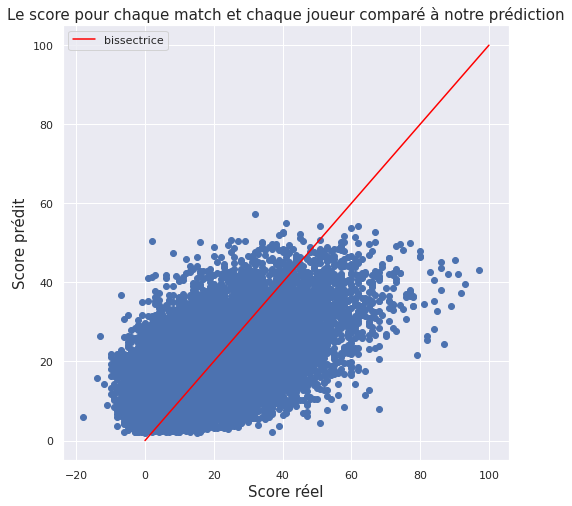

In [24]:
afficher_model(model, X, y)

Au vue du MAE et du graphique on voit qu'il vaut mieux utiliser un *Ridge* comme modèle. On est conforté par l'idée que Sélim nous avait dit que le *Ridge* fonctionne mieux lorsque les variables explicatives sont corrélées entres elles ce qui est plutôt le cas ici.

In [25]:
best_model = Ridge(alpha=alpha_ridge)
best_model.fit(X,y)

Ridge()

## 4 - Expérimentations 

Maintenenant que nous avons le modèle et l'hyperparamètre essayons de modifier d'autre paramètres pour voir l'effet que cela a sur la prédiction. 

Dans un premier temps, on enlève les variables `PLAYER_ID` car le fait qu'un joueur est bon doit normalement se resentir dans la moyenne de ces points.

In [26]:
df_new = df.drop(['PLAYER_ID', 'GAME_DATE'], axis=1)
df_model_new = pd.get_dummies(df_new)

X_new = df_model_new.drop('SCORE', axis=1)

In [28]:
model = Lasso(alpha=alpha_ridge)
model.fit(X_new,y)

R = model.score(X_new, y)
MAE = mean_absolute_error(model.predict(X_new), y)
print(f'R^2 = {R:.3}, MAE = {MAE:.3}')

R^2 = 0.381, MSE = 8.84


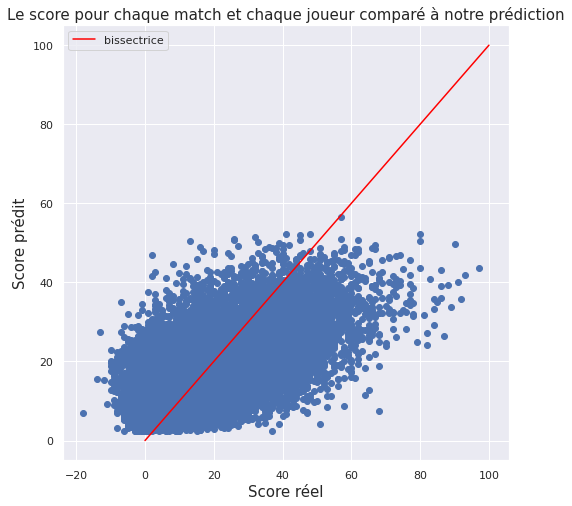

In [29]:
afficher_model(model, X_new, y)

On voit que enlever les joueurs diminue la précision de notre modèle donc on garde les joueurs.

## 5 - Prédictions

Maintenant que nous avons un modèle optimisé pour notre jeu de données nous allons l'utiliser pour prédir les meilleurs joueurs. 

In [30]:
def prediction_date(date, nb=5):
    global df_model, df
    
    df_date = df_model[df_model.GAME_DATE == date]

    X_date = df_date.drop(['SCORE', 'GAME_DATE', 'SPLIT'], axis=1)
    y_date = df_date.SCORE

    # On récupère les nb plus gros score prédis de la journée
    best_pred = pd.Series(best_model.predict(X_date), name='SCORE_PRED')  \
                                    .sort_values(ascending=False).head(nb)

    # On récupère les noms de ces gros score 
    player_id = df[df.GAME_DATE == date].PLAYER_ID.reset_index(drop=True)
    pred_rank = pd.Series(best_pred.index.map(player_id.to_dict()), 
                          name='PLAYER_ID')
    
    return(pred_rank)

In [31]:
pred_rank = prediction_date('2020-02-10')
players_id2name(pred_rank.to_frame()).drop('PLAYER_ID', axis=1)

,NAME
0,Anthony Davis
1,LeBron James
2,Nikola Jokic
3,Trae Young
4,John Collins


Testons nos predicitons. Comme métrique nous allons prendre le meilleur joueur pour une date donnée puis vérifier quelle a été sa places en réalité.

In [32]:
def error_prediction(date, nb=1):
    global df
    
    # On récupère la prédiction
    pred_rank = prediction_date(date, nb)

    # On récupère le rang réel de la journée
    real_rank = df[df.GAME_DATE == date].sort_values('SCORE', ascending=False)  \
                                        .PLAYER_ID.reset_index(drop=True)
    # On inverse l'index et le PLAYER_ID
    real_rank = pd.Series(real_rank.index.values, index=real_rank )

    # On obtient les rangs des 5 plus gros scores prédis
    return(pred_rank.map(real_rank).to_frame().apply(lambda x: x+1 - x.index)) \
                                                .PLAYER_ID.values

In [33]:
error = [error_prediction(date) for date in df_model.GAME_DATE.unique()]
error = [item for sublist in error for item in sublist]

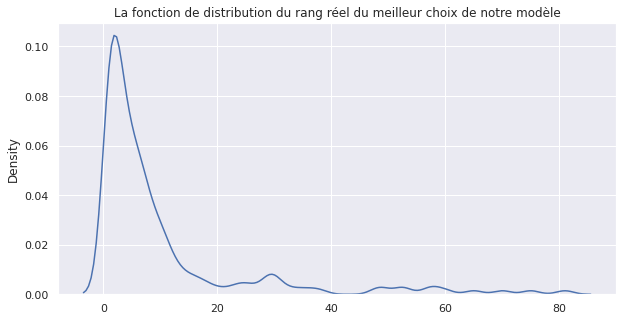

In [37]:
plt.figure(figsize=(10,5))

plt.title(label="La fonction de distribution du rang réel du meilleur choix de notre modèle")

sns.kdeplot(np.array(error), bw_method=0.1)
plt.show()

La fonction de densité nous montre que notre prédiction du meilleur joueur n'est vraiment pas mauvaise.